<a href="https://colab.research.google.com/github/SufyAD/AI-ML/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-4/2_sub_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph.

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate!

In short, communication is **done with over-lapping keys**:

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
import os
from google.colab import userdata

%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: LANGCHAIN_API_KEY=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


In [3]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

In [86]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.types import Command
from typing import Literal

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

In [87]:
display(Command.__init__)

<function langgraph.types.Command.__init__(self, *, graph: Optional[str] = None, update: Optional[Any] = None, resume: Union[Any, dict[str, Any], NoneType] = None, goto: Union[langgraph.types.Send, Sequence[Union[langgraph.types.Send, str]], str] = ()) -> None>

Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.
**Updated this thing with slack**

In [88]:
def get_failures(state) -> Command[Literal["generate_summary"]]:
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    state = {
        "failures": failures,
        "processed_logs": [f"failure-on-log-{failure['id']}" for failure in failures]
    }
    goto = "generate_summary"
    return Command(update=state,
                   goto=goto
              )

def generate_summary(state) -> Command[Literal["__end__"]]:
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation, therefore, your grades are set to fail after careful review"
    state = {
        "fa_summary": fa_summary,
        "processed_logs": [f"summary-on-failure-log-{failure['id']}" for failure in failures]
    }
    goto = "__end__"
    return Command(
        update=state,
        goto=goto
    )

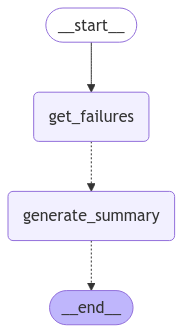

In [89]:
fa_builder: StateGraph = StateGraph(FailureAnalysisState, input=FailureAnalysisState, output=FailureAnalysisOutputState)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

# we no need any edges as of now, bcz we have introduced Command function
# fa_builder.add_edge("get_failures", "generate_summary")
# fa_builder.add_edge("generate_summary", END)

graph: CompiledStateGraph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [90]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

In [91]:
def generate_summary(state)->Command[Literal["send_to_slack"]]:
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    state = {
        "qs_summary": summary,
        "processed_logs": [f"summary-on-pass-log-{log['id']}" for log in cleaned_logs]
    }
    goto = "send_to_slack"
    return Command(
         update=state,
         goto = goto
                   )

def send_to_slack(state)->Command[Literal["__end__"]]:
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    goto = "__end__"
    report = f"On basis of this summary: {qs_summary}, your grades are set to pass, and thus, you are PASSED now."
    return Command(
        update = {"report": report},
        goto = goto
    )

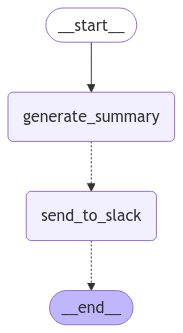

In [92]:
qs_builder: StateGraph = StateGraph(state_schema=QuestionSummarizationState, input=QuestionSummarizationState, output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
# qs_builder.add_edge("generate_summary", "send_to_slack")
# qs_builder.add_edge("send_to_slack", END)

graph: CompiledStateGraph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`.

And we add our sub-graphs as nodes!

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified.

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_logs`.

In [93]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS/PASSED sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state)->Command[Literal["question_summarization", "failure_analysis"]]:
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs
    cleaned_logs = raw_logs
    goto = ["question_summarization", "failure_analysis"]
    return Command(update={"cleaned_logs": cleaned_logs},
                   goto=goto
                   )

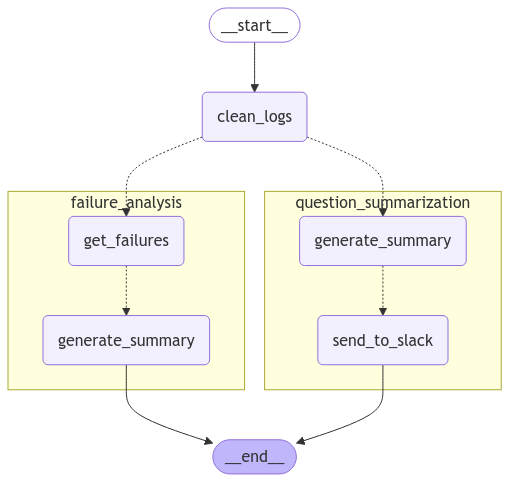

In [94]:
entry_builder: StateGraph = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
# entry_builder.add_edge("clean_logs", "failure_analysis")
# entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph: CompiledStateGraph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [95]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

In [96]:
raw_logs = [question_answer, question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r